# Handwritten Arabic Digits & Letters Recognition

## Submitted To Dr. Ghada Khoriba

### **Contributers:**
#### * **Nour Nasser**
#### * **Abdalrahman Hassan**
#### * **Ramez Shakran** 
#### * **Hussien Ehab** 
#### * **Mahmoud Ibrahim** 

## Data Exploration


1. Import libraries


In [1]:
# Import main libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display
import csv
from PIL import Image
from scipy.ndimage import rotate
import keras as keras
import tensorflow as tf
%matplotlib inline

### Loading Arabic Letters Dataset

In [2]:
# Loading dataset into dataframes
training_letters_images = pd.read_csv('training images.csv')
training_letters_labels = pd.read_csv('training labels.csv')
testing_letters_images = pd.read_csv('testing images.csv')
testing_letters_labels = pd.read_csv('testing labels.csv')

# print statistics about the dataset
print("There are %d training arabic letter images of 64x64 pixels." %training_letters_images.shape[0])
print("There are %d testing arabic letter images of 64x64 pixels." %testing_letters_images.shape[0])
training_letters_images.head()

There are 13439 training arabic letter images of 64x64 pixels.
There are 3359 testing arabic letter images of 64x64 pixels.


,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.3438,0.3439,0.3440,0.3441,0.3442,0.3443,0.3444,0.3445,0.3446,0.3447
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Loading Arabic Digits Dataset

In [3]:
# Loading dataset into dataframes
training_digits_images = pd.read_csv("training digits images.csv")
training_digits_labels = pd.read_csv("training digits labels.csv")
testing_digits_images = pd.read_csv("testing digits images.csv")
testing_digits_labels = pd.read_csv("testing digits labels.csv")

# print statistics about the dataset
print("There are %d training arabic digit images of 64x64 pixels." %training_digits_images.shape[0])
print("There are %d testing arabic digit images of 64x64 pixels." %testing_digits_images.shape[0])

There are 59999 training arabic digit images of 64x64 pixels.
There are 9999 testing arabic digit images of 64x64 pixels.


### Convert csv values to an image 
Writting a method to be used later if we want visualization of an image from its pixels values.

In [4]:
from scipy.ndimage import rotate

# Define function and its arguments
def convertValuesToImages(image_values, display=False):
    # Convert input values to numpy array with uint8 data type and reshape to (64, 64) shape
    image_array = np.array(image_values, dtype=np.uint8).reshape(64, 64)

    # Apply flip and rotation transformations to the input image array
    # Flip along the vertical axis and rotate by 90 degrees clockwise
    modified_image = np.rot90(np.fliplr(image_array))

    # Display the modified image if the display argument is set to True
    if display:
        Image.fromarray(modified_image).show()

    # Convert the modified image array to a PIL image object and return it
    return Image.fromarray(modified_image)

### Visualizing some examples

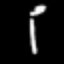

In [5]:
convertValuesToImages(training_letters_images.loc[0], True)

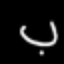

In [6]:
convertValuesToImages(training_letters_images.loc[12], True)

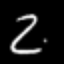

In [7]:
convertValuesToImages(training_letters_images.loc[37], True)

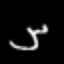

In [8]:
convertValuesToImages(training_letters_images.loc[3000], True)

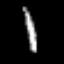

In [9]:
convertValuesToImages(training_digits_images.loc[0], True)

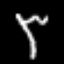

In [10]:
convertValuesToImages(training_digits_images.loc[2], True)

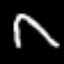

In [11]:
convertValuesToImages(training_digits_images.loc[7], True)

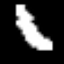

In [12]:
convertValuesToImages(training_digits_images.loc[9], True)

## Data Preprocessing

### Image Normalization
We rescale the images by dividing every pixel in the image by 255 to make them into range [0, 1]

In [13]:
training_digits_images_scaled = training_digits_images.values.astype('float32')/255
training_digits_labels = training_digits_labels.values.astype('int32')
testing_digits_images_scaled = testing_digits_images.values.astype('float32')/255
testing_digits_labels = testing_digits_labels.values.astype('int32')

training_letters_images_scaled = training_letters_images.values.astype('float32')/255
training_letters_labels = training_letters_labels.values.astype('int32')
testing_letters_images_scaled = testing_letters_images.values.astype('float32')/255
testing_letters_labels = testing_letters_labels.values.astype('int32')

In [14]:
print("Training images of digits after scaling")
print(training_digits_images_scaled.shape)
training_digits_images_scaled[0:5]

Training images of digits after scaling
(59999, 4096)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [15]:
print("Training images of letters after scaling")
print(training_letters_images_scaled.shape)
training_letters_images_scaled[0:5]

Training images of letters after scaling
(13439, 4096)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Encoding Categorical Labels
From the labels csv files we can see that labels are categorical values and it is a multi-class classification problem. 

Our outputs are in the form of:
* Digits from 0 to 9 have categories numbers from 0 to 9
* Letters from ’alef’ to ’yeh’ have categories numbers from 10 to 37

**Here we will encode these categories values using One Hot Encoding with keras.**

One-hot encoding transforms integer to a binary matrix where the array contains only one ‘1’ and the rest elements are ‘0’.



In [16]:

from keras.utils import to_categorical

# one hot encoding
# number of classes = 10 (digits classes) + 28 (arabic alphabet classes)
number_of_classes = 38
training_letters_labels_encoded = to_categorical(training_letters_labels, num_classes=number_of_classes)
testing_letters_labels_encoded = to_categorical(testing_letters_labels, num_classes=number_of_classes)
training_digits_labels_encoded = to_categorical(training_digits_labels, num_classes=number_of_classes)
testing_digits_labels_encoded = to_categorical(testing_digits_labels, num_classes=number_of_classes)

In [17]:
print(training_digits_labels_encoded)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [18]:
print(training_letters_labels_encoded)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


### Reshaping Input Images to 64x64x1


When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape
(nb_samples,rows,columns,channels)

where nb_samples corresponds to the total number of images (or samples), and rows, columns, and channels correspond to the number of rows, columns, and channels for each image, respectively.

**So we will reshape the input images to a 4D tensor with shape
(nb_samples, 64, 64 ,1)** as we use grayscale images of 64x64 pixels.

In [19]:
# reshape input digit images to 64x64x1
training_digits_images_scaled = training_digits_images_scaled.reshape([-1, 64, 64, 1])
testing_digits_images_scaled = testing_digits_images_scaled.reshape([-1, 64, 64, 1])

# reshape input letter images to 64x64x1
training_letters_images_scaled = training_letters_images_scaled.reshape([-1, 64, 64, 1])
testing_letters_images_scaled = testing_letters_images_scaled.reshape([-1, 64, 64, 1])

print(training_digits_images_scaled.shape, training_digits_labels_encoded.shape, testing_digits_images_scaled.shape, testing_digits_labels_encoded.shape)
print(training_letters_images_scaled.shape, training_letters_labels_encoded.shape, testing_letters_images_scaled.shape, testing_letters_labels_encoded.shape)

(59999, 64, 64, 1) (59999, 38) (9999, 64, 64, 1) (9999, 38)
(13439, 64, 64, 1) (13439, 38) (3359, 64, 64, 1) (3359, 38)


### Merging Letters and Digits Datasets

In [20]:
training_data_images = np.concatenate((training_digits_images_scaled, training_letters_images_scaled), axis=0) 
training_data_labels = np.concatenate((training_digits_labels_encoded, training_letters_labels_encoded), axis=0)
print("Total Training images are {} images of shape".format(training_data_images.shape[0]))
print(training_data_images.shape, training_data_labels.shape)


testing_data_images = np.concatenate((testing_digits_images_scaled, testing_letters_images_scaled), axis=0) 
testing_data_labels = np.concatenate((testing_digits_labels_encoded, testing_letters_labels_encoded), axis=0)
print("Total Testing images are {} images of shape".format(testing_data_images.shape[0]))
print(testing_data_images.shape, testing_data_labels.shape)


Total Training images are 73438 images of shape
(73438, 64, 64, 1) (73438, 38)
Total Testing images are 13358 images of shape
(13358, 64, 64, 1) (13358, 38)


## Designing Model Architecture

Now we will make a method which creates the model architecture with the specified optimizer and activation functions.

In [21]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense

def create_model(optimizer='adam', kernel_initializer='he_normal', activation='relu'):
  # create model
  model = Sequential()
  model.add(Conv2D(filters=16, kernel_size=3, padding='same', input_shape=(64, 64, 1), kernel_initializer=kernel_initializer, activation=activation))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=32, kernel_size=3, padding='same', kernel_initializer=kernel_initializer, activation=activation))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=64, kernel_size=3, padding='same', kernel_initializer=kernel_initializer, activation=activation))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=128, kernel_size=3, padding='same', kernel_initializer=kernel_initializer, activation=activation))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.2))
  model.add(GlobalAveragePooling2D())
  
  #Fully connected final layer
  model.add(Dense(38, activation='softmax'))

  # Compile model
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
  return model

Let’s understand above code step by step.

* The first hidden layer is a convolutional layer. The layer has 16 feature maps, which with the size of 3×3 and an activation function which is relu. This is the input layer, expecting images with the structure outlined above.
* The second layer is Batch Normalization which solves having distributions of the features vary across the training and test data, which breaks the IID assumption. We use it to help in two ways faster learning and higher overall accuracy. 
* The third layer is the MaxPooling layer. MaxPooling layer is used to down-sample the input to enable the model to make assumptions about the features so as to reduce overfitting. It also reduces the number of parameters to learn, reducing the training time.
* The next layer is a Regularization layer using dropout. It is configured to randomly exclude 20% of neurons in the layer in order to reduce overfitting.
* Another hidden layer with 32 feature maps with the size of 3×3 and a relu activation function to capture more features from the image.
* Other hidden layers with 64 and 128 feature maps with the size of 3×3 and a relu activation function to capture complex patterns from the image which will decribe the digits and letters later.
* More MaxPooling, Batch Normalization, Regularization and GlobalAveragePooling2D layers.
* The last layer is the output layer with 10 neurons (number of output classes) and it uses softmax activation function as we have multi-classes. Each neuron will give the probability of that class.

I used categorical_crossentropy as a loss function because its a multi-class classification problem. I used accuracy as metrics to improve the performance of our neural network.

## Model Summary And Visualization

Let's see the model summary.

In [22]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        160       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       1

Keras support plotting the model in keras.utils.vis_utils module which provides utility functions to plot a Keras model using graphviz.

To be able to use that utility we should first install pydot and graphviz modules. This can be done by running the following code cell then restart the runtime environment.

Now we can plot the model and save it to a file also.

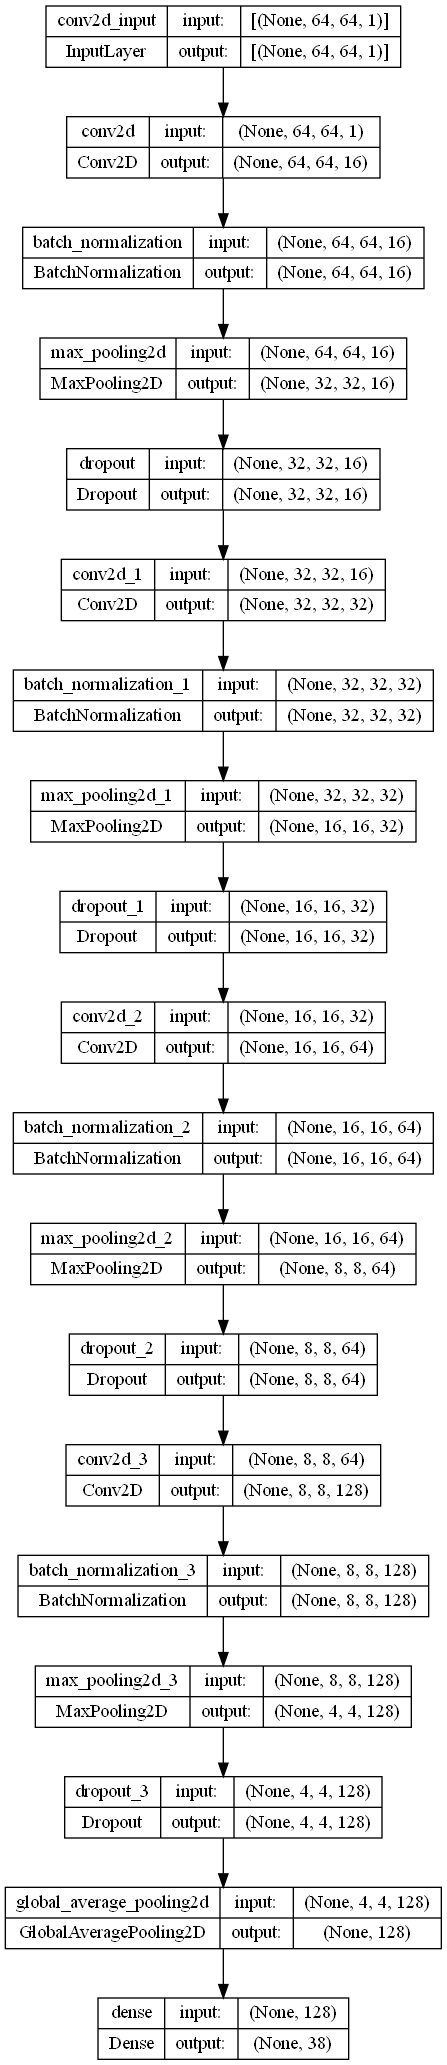

In [23]:
from keras.utils import plot_model

plot_model(model, to_file="model.png", show_shapes=True)
from IPython.display import Image as IPythonImage
display(IPythonImage('model.png'))

## Parameters Tuning

We will tune the parameters optimizer, kernel_initializer and activation.

In [24]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# define the grid search parameters
optimizer = ['RMSprop', 'Adam', 'Adagrad', 'Nadam']
kernel_initializer = ['normal', 'uniform']
activation = ['relu', 'linear', 'tanh']

param_grid = dict(optimizer=optimizer, kernel_initializer=kernel_initializer, activation=activation)

# count number of different parameters values combinations
parameters_number = 1
for x in param_grid:
  parameters_number = parameters_number * len(param_grid[x]) 
print("Number of different parameter combinations = {}".format(parameters_number))

Number of different parameter combinations = 24


We will try different models with different parameters to find the best parameter values.

In [ ]:
epochs = 5
batch_size = 20 # 20 divides the training data samples

#creating the models with different hyperparameters
for a,b,c in [(x,y,z) for x in optimizer for z in activation for y in kernel_initializer]:
    params = {'optimizer' : a , 'kernel_initializer' : b , 'activation' : c}
    print(params)
    curr_model = create_model(a, b, c)
    curr_model.fit(training_data_images, training_data_labels, 
                    validation_data=(testing_data_images, testing_data_labels),
                    epochs=epochs, batch_size=batch_size, verbose=1)
    print("=============================================================================")

**Considering the results above, it was found the the best parameters are:**
* **Optimizer: Adam**
* **Kernel_initializer: uniform**
* **Activation: relu** 

In [25]:
#creating the model with the best parameters
model = create_model(optimizer='Adam', kernel_initializer='uniform', activation='relu')

## Training the Mode

### Fitting the Model


In [26]:
from keras.callbacks import ModelCheckpoint  

#The ModelCheckpoint callback is being used to save the weights of the trained model to a file
#This allows the model to be reused later without having to train it again. 
#The `verbose` parameter set to 1 means that progress updates will be printed during training
checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)
history = model.fit(training_data_images, training_data_labels, 
                    validation_data=(testing_data_images, testing_data_labels),
                    epochs=10, batch_size=20, verbose=1, callbacks=[checkpointer])

Epoch 1/10
3671/3672 [============================>.] - ETA: 0s - loss: 0.3223 - accuracy: 0.9147
Epoch 1: val_loss improved from inf to 0.76771, saving model to weights.hdf5
3672/3672 [==============================] - 136s 37ms/step - loss: 0.3223 - accuracy: 0.9147 - val_loss: 0.7677 - val_accuracy: 0.7549
Epoch 2/10
3671/3672 [============================>.] - ETA: 0s - loss: 0.1045 - accuracy: 0.9682
Epoch 2: val_loss improved from 0.76771 to 0.10629, saving model to weights.hdf5
3672/3672 [==============================] - 136s 37ms/step - loss: 0.1045 - accuracy: 0.9682 - val_loss: 0.1063 - val_accuracy: 0.9694
Epoch 3/10
3671/3672 [============================>.] - ETA: 0s - loss: 0.0806 - accuracy: 0.9749
Epoch 3: val_loss did not improve from 0.10629
3672/3672 [==============================] - 131s 36ms/step - loss: 0.0806 - accuracy: 0.9749 - val_loss: 0.1287 - val_accuracy: 0.9631
Epoch 4/10
3672/3672 [==============================] - ETA: 0s - loss: 0.0675 - accuracy: 0.

### Plotting Loss and Accuracy Curves with Epochs

In [ ]:
# import matplotlib.pyplot as plt

# def plot_loss_accuracy(history):
#   # Loss Curves
#   plt.figure(figsize=[8,6])
#   plt.plot(history.history['loss'],'r',linewidth=3.0)
#   plt.plot(history.history['val_loss'],'b',linewidth=3.0)
#   plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
#   plt.xlabel('Epochs ',fontsize=16)
#   plt.ylabel('Loss',fontsize=16)
#   plt.title('Loss Curves',fontsize=16)

#   # Accuracy Curves
#   plt.figure(figsize=[8,6])
#   plt.plot(history.history['acc'],'r',linewidth=3.0)
#   plt.plot(history.history['val_acc'],'b',linewidth=3.0)
#   plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
#   plt.xlabel('Epochs ',fontsize=16)
#   plt.ylabel('Accuracy',fontsize=16)
#   plt.title('Accuracy Curves',fontsize=16) 

In [ ]:
# plot_loss_accuracy(history)

### Load the Model with the Best Validation Loss


In [27]:
model.load_weights('weights.hdf5')

## Testing the Model

In [28]:
# Final evaluation of the model
metrics = model.evaluate(testing_data_images, testing_data_labels, verbose=1)
print("Test Accuracy: {}".format(metrics[1]))
print("Test Loss: {}".format(metrics[0]))

418/418 [==============================] - 5s 13ms/step - loss: 0.0552 - accuracy: 0.9838
Test Accuracy: 0.983829915523529
Test Loss: 0.05517462641000748


## Training our best model with Increasing the number of epochs to see if we get a better accuracy

In [29]:
epochs = 15
batch_size = 20

checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)

history = model.fit(training_data_images, training_data_labels, 
                    validation_data=(testing_data_images, testing_data_labels),
                    epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[checkpointer])
          
model.load_weights('weights.hdf5')
# plot_loss_accuracy(history)

Epoch 1/15
3672/3672 [==============================] - ETA: 0s - loss: 0.0567 - accuracy: 0.9821
Epoch 1: val_loss improved from inf to 0.07045, saving model to weights.hdf5
3672/3672 [==============================] - 157s 43ms/step - loss: 0.0567 - accuracy: 0.9821 - val_loss: 0.0704 - val_accuracy: 0.9777
Epoch 2/15
3672/3672 [==============================] - ETA: 0s - loss: 0.0506 - accuracy: 0.9843
Epoch 2: val_loss did not improve from 0.07045
3672/3672 [==============================] - 161s 44ms/step - loss: 0.0506 - accuracy: 0.9843 - val_loss: 0.1126 - val_accuracy: 0.9641
Epoch 3/15
3671/3672 [============================>.] - ETA: 0s - loss: 0.0477 - accuracy: 0.9852
Epoch 3: val_loss improved from 0.07045 to 0.06377, saving model to weights.hdf5
3672/3672 [==============================] - 159s 43ms/step - loss: 0.0477 - accuracy: 0.9852 - val_loss: 0.0638 - val_accuracy: 0.9820
Epoch 4/15
3671/3672 [============================>.] - ETA: 0s - loss: 0.0441 - accuracy: 0.

NameError: name 'plot_loss_accuracy' is not defined

## Testing our model after training on 15 epochs

In [61]:
# Final evaluation of the model
metrics = model.evaluate(testing_data_images, testing_data_labels, verbose=1)
print("Test Accuracy: {}".format(metrics[1]))
print("Test Loss: {}".format(metrics[0]))

418/418 [==============================] - 5s 12ms/step - loss: 0.0450 - accuracy: 0.9882
Test Accuracy: 0.988246738910675
Test Loss: 0.04496202990412712


After training the model on more 15 epochs we got a better accuracy . Also the test accuracy imorpved from from **98.286% to 98.82%** and we think that increasing the number of epochs even more may improve the accuracy even more




In [56]:
model_json =model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [57]:
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


## Comparing our model with simple vanilla cnn model on the same data

In [60]:
from keras.models import Sequential
from keras.layers import Conv2D, GlobalAveragePooling2D, Dense

def create_model():
    # Define the baseline model architecture
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=3, padding='same', input_shape=(64, 64, 1), activation='relu')) # Input layer
    model.add(GlobalAveragePooling2D())
    model.add(Dense(38, activation = 'softmax')) # Output layer => output dimension = 38 as it is multi-class

    # Compile the model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='Adam')
    return model

def train_model(model, train_images, train_labels, epochs, batch_size, test_images, test_labels):
    # Train the model
    history = model.fit(train_images, train_labels, 
                  validation_data=(test_images, test_labels),
                  epochs=epochs, batch_size=batch_size, verbose=1)

    # Evaluate the model on the test set
    metrics = model.evaluate(test_images, test_labels, verbose=1)
    print("Model Test Accuracy: {}".format(metrics[1]))
    print("Model Test Loss: {}".format(metrics[0]))
    return history

# Train the baseline model using the created functions
epochs = 5
batch_size = 20
model = create_model()
history = train_model(model, training_data_images, training_data_labels, epochs, batch_size, testing_data_images, testing_data_labels)

Epoch 1/5
3672/3672 [==============================] - 37s 10ms/step - loss: 2.6770 - accuracy: 0.1903 - val_loss: 2.6653 - val_accuracy: 0.2213
Epoch 2/5
3672/3672 [==============================] - 60s 16ms/step - loss: 2.4276 - accuracy: 0.2674 - val_loss: 2.5695 - val_accuracy: 0.2705
Epoch 3/5
3672/3672 [==============================] - 36s 10ms/step - loss: 2.3447 - accuracy: 0.2993 - val_loss: 2.4942 - val_accuracy: 0.2832
Epoch 4/5
3672/3672 [==============================] - 55s 15ms/step - loss: 2.2720 - accuracy: 0.3310 - val_loss: 2.4284 - val_accuracy: 0.2972
Epoch 5/5
418/418 [==============================] - 2s 4ms/step - loss: 2.3620 - accuracy: 0.3218
Baseline Model Test Accuracy: 0.3217547535896301
Baseline Model Test Loss: 2.3620481491088867


We get test accuracy of **32.37%** from the baseline Model (vanilla). so our project outperfomed it as our test accuracy were **98.82%**

## Predict Image Classes

In [76]:
# import numpy as np

def get_predicted_classes(model, data, labels=None):
    """
    Gets predicted classes for given input data using the specified model.

    Args:
    model -- the trained model
    data -- input data to be used for prediction
    labels -- true class labels for the input data

    Returns:
    A tuple of predicted classes and true classes (if labels are provided).
    """
    image_predictions = model.predict(data)
    predicted_classes = np.argmax(image_predictions, axis=1)
    if labels is not None:
        true_classes = np.argmax(labels, axis=1)
        return predicted_classes, true_classes
    else:
        return predicted_classes


# def get_predicted_classes(model, data, labels=None):
#   image_predictions = model.predict(data)
#   predicted_classes = np.argmax(image_predictions, axis=1)
#   true_classes = np.argmax(labels, axis=1)
#   return predicted_classes, true_classes

## Comparing Evaluation Metrics between Vanilla CNN Model and Our Final Model


In [77]:
!pip install joblib
!pip install threadpoolctl

In [78]:
from sklearn.metrics import classification_report
# import joblib

def get_classification_report(y_true, y_pred):
  print(classification_report(y_true, y_pred))

In [79]:
y_pred, y_true = get_predicted_classes(model, testing_data_images, testing_data_labels)
get_classification_report(y_true, y_pred)

418/418 [==============================] - 5s 12ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       999
           1       0.99      0.99      0.99      1000
           2       0.98      1.00      0.99      1000
           3       1.00      0.99      1.00      1000
           4       1.00      0.99      1.00      1000
           5       0.99      0.99      0.99      1000
           6       1.00      1.00      1.00      1000
           7       1.00      1.00      1.00      1000
           8       1.00      1.00      1.00      1000
           9       1.00      0.99      1.00      1000
          10       1.00      1.00      1.00       119
          11       1.00      0.99      1.00       120
          12       0.85      0.99      0.92       120
          13       0.98      0.93      0.95       120
          14       0.99      1.00      1.00       120
          15       0.98      0.99      0.98       120
          16       0.98  

In [80]:
y_pred, y_true = get_predicted_classes(baseline_model, testing_data_images, testing_data_labels)
get_classification_report(y_true, y_pred)

418/418 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       999
           1       0.24      0.89      0.38      1000
           2       0.26      0.03      0.06      1000
           3       0.28      0.23      0.25      1000
           4       0.23      0.73      0.35      1000
           5       0.51      0.66      0.58      1000
           6       0.20      0.12      0.15      1000
           7       0.00      0.00      0.00      1000
           8       0.28      0.70      0.41      1000
           9       0.24      0.04      0.06      1000
          10       0.00      0.00      0.00       119
          11       0.00      0.00      0.00       120
          12       0.00      0.00      0.00       120
          13       0.00      0.00      0.00       120
          14       0.00      0.00      0.00       120
          15       0.00      0.00      0.00       120
          16       0.00   

C:\Users\lenovo\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lenovo\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lenovo\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)